# Práctico 4 de Redes Neuronales

In [1]:
import torch
import torchvision as tv
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.utils import save_image
from tqdm import tqdm

from torchviz import make_dot

import os
import matplotlib.pyplot as plt

from PIL import Image

import numpy as np

## MNIST Dataset

In [2]:
#transform = transforms.Compose([transforms.Resize([1,784]), transforms.ToTensor()])
transform = transforms.Compose([transforms.ToTensor()])

In [3]:
MNIST = tv.datasets.MNIST(os.path.abspath(os.path.curdir),
                          train=False,
                          transform=transform,
                          download=True)

In [4]:
MNIST.train_data.shape

/home/mauri/anaconda3/envs/vg-dialogue/lib/python3.6/site-packages/torchvision/datasets/mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


torch.Size([10000, 28, 28])

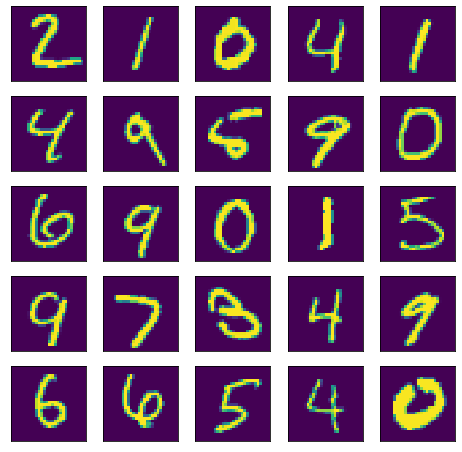

In [5]:
fig=plt.figure(figsize=(8, 8))
cols = 5
rows = 5
for i in range(1, cols*rows +1):
    img = MNIST.data[i]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
plt.show()

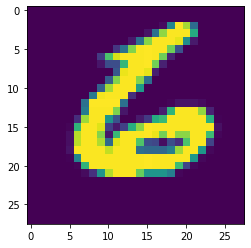

In [6]:
plt.imshow(MNIST.data[-1])

In [7]:
dataloader = torch.utils.data.DataLoader(MNIST, batch_size=1, shuffle=False, num_workers=1)

In [8]:
reverse_transform = transforms.Compose([transforms.ToPILImage(), transforms.Resize([28,28])])

## Autoencoder

In [9]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder,self).__init__()
        
        self.autouenc = nn.Sequential()
        self.encoder  = nn.Linear(784, 64)
        self.decoder  = nn.Linear(64, 784)
        
        self.autouenc.add_module('enc',self.encoder)
        self.autouenc.add_module('dec',self.decoder)
        
    def forward(self, x):
        pred = F.relu(self.encoder(x))
        pred = F.relu(self.decoder(pred))
        return pred

In [11]:
model = Autoencoder().cpu()
model.load_state_dict(torch.load('Autoencoder19', map_location=torch.device('cpu')))
model.eval()

distance = nn.MSELoss()

mloss = torch.FloatTensor()

with torch.no_grad():
    for data in tqdm(dataloader):
        img, _ = data
        img = Variable(img.view(-1,28*28)).cpu()
        # ===================forward=====================
        output = model(img)
        loss = distance(output, img)
        mloss = torch.cat([mloss, loss.data.reshape([1])])

    # ===================log========================
    print('test loss:{:.4f}'.format(torch.mean(mloss)))

100%|██████████| 10000/10000 [00:15<00:00, 652.05it/s]

test loss:0.0075


In [41]:
enumdata = enumerate(dataloader)
topil = transforms.ToPILImage()

orig = []
modl = []

for i in range(5):
    u, ig = next(enumdata)
    out = model(ig[0].view(-1,28*28))
    mimg = topil(out.data.view(-1, 28, 28))
    oimg = topil(ig[0].view(-1, 28, 28))
    orig.append(oimg)
    modl.append(mimg)

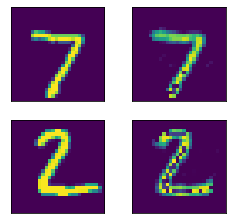

In [52]:
fig=plt.figure(figsize=(4, 10))
cols = 2
rows = 5
for i in range(1, rows-2):
    fig.add_subplot(rows, cols, 2*i-1)
    plt.imshow(orig[i-1])
    plt.xticks([])
    plt.yticks([])
    fig.add_subplot(rows, cols, 2*i)
    plt.imshow(modl[i-1])
    plt.xticks([])
    plt.yticks([])
plt.show()

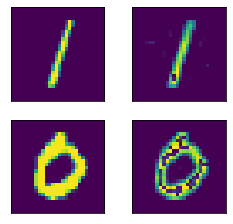

In [54]:
fig=plt.figure(figsize=(4, 10))
cols = 2
rows = 5
for i in range(3, rows):
    fig.add_subplot(rows, cols, 2*i-1)
    plt.imshow(orig[i-1])
    plt.xticks([])
    plt.yticks([])
    fig.add_subplot(rows, cols, 2*i)
    plt.imshow(modl[i-1])
    plt.xticks([])
    plt.yticks([])
plt.show()

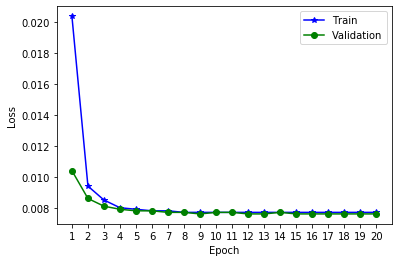

In [68]:
train_log = open('train_log')
tlog = []
dlog = []
for line in train_log:
    _, _, _, tstep, _, dstep = line.strip().split(' ')
    tlog.append(float(tstep[5:-1]))
    dlog.append(float(dstep[5:]))
    
x = np.arange(1,21)
tcurve = plt.plot(x, tlog, marker='*', c='b')
dcurve = plt.plot(x, dlog, marker='o', c='g')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xticks(x)
plt.legend(['Train', 'Validation'])
plt.show()

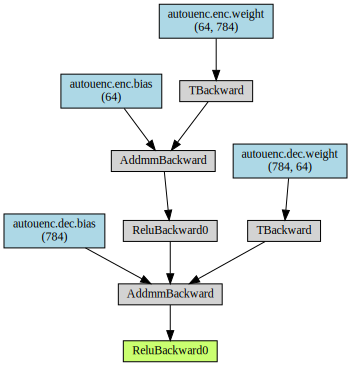

In [72]:
mkdot_model = Autoencoder()
x = torch.zeros([1,784])
out = mkdot_model(x)
make_dot(out, params=dict(mkdot_model.named_parameters()))